# Chordal graphs

A graph $G$ is chordal, if it does not contain an induced cycle of length $\geq 4$. Equivalently, if every cycle $C$ of length $\geq 4$ in $G$ contains a chord.

### Recognition of chordal graphs

A *perfect elemination ordering* is an ordering $v_1, v_2, \dots, v_n$ of vertices of $G$ so that $v_i$ is *simplicial vertex* in $G[v_{i}, v_{i+1}, \dots, v_n]$, i.e., $v_i$ and neighbors after it in the ordering form a clique.

A graph $G$ is chordal if and only if it admits a perfect elimination ordering.


### Exercises

1. Implement `max_cardinality_search(G)` which returns PEO of `G` using maximal cardinality search algorithm (see [Lecture notes](http://matematika.fri.uni-lj.si/dm/discrete_mathematics.pdf), Algorithm 7.1).

2. Write function `is_chordal(G)` which checks if graph `G` is chordal. Use algorithm 7.2 from Lecture notes. See also comments in the code below.

3. Write function `color_chordal_graph(G)` which returns minimal (optimal) coloring of chordal graph `G`. See Lecture notes.

4. *Write a function `maximal_cliques_chordal(G)` which returns a list of distinct maximal cliques in a chordal graph `G`.

In [1]:
def max_cardinality_search(G):
    """
    Maximum cardinality search algorithm for finding a perfect elimination ordering.
    
    Parameters:
    G -- a SageMath graph
    
    Returns:
    A list of vertices representing a perfect elimination ordering
    """
    n = G.order()
    unnumbered = set(G.vertices())
    numbered = []
    # Dictionary to keep track of how many numbered neighbors each vertex has
    weight = {v: 0 for v in G.vertices()}
    
    for i in range(n):
        # Find unnumbered vertex with maximum weight
        max_weight = -1
        max_v = None
        for v in unnumbered:
            if weight[v] > max_weight:
                max_weight = weight[v]
                max_v = v
        
        # Add chosen vertex to the ordering
        numbered.append(max_v)
        unnumbered.remove(max_v)
        
        # Update weights of unnumbered neighbors
        for u in G.neighbors(max_v):
            if u in unnumbered:
                weight[u] += 1
    
    # We want the PEO, so reverse the order
    return numbered[::-1]

def is_chordal(G):
    """
    Test if graph G is chordal using maximum cardinality search.
    
    Parameters:
    G -- a SageMath graph
    
    Returns:
    Boolean indicating whether G is chordal
    """
    peo = max_cardinality_search(G)
    n = G.order()
    
    # Check if peo is a perfect elimination ordering
    for i in range(n):
        vi = peo[i]
        
        # Find neighbors of vi that appear later in the ordering
        later_neighbors = [peo[j] for j in range(i+1, n) if G.has_edge(vi, peo[j])]
        
        if not later_neighbors:
            continue
            
        # Find the neighbor with smallest index
        j_min = min(range(i+1, n), key=lambda j: j if G.has_edge(vi, peo[j]) else n+1)
        vj = peo[j_min]
        
        # Check if vj is adjacent to all other later neighbors of vi
        for vk in later_neighbors:
            if vk != vj and not G.has_edge(vj, vk):
                return False
                
    return True

def color_chordal_graph(G):
    """
    Optimally color a chordal graph G using a greedy algorithm.
    
    Parameters:
    G -- a SageMath graph
    
    Returns:
    Dictionary mapping vertices to colors (integers starting from 0)
    """
    if not is_chordal(G):
        raise ValueError("The graph is not chordal")
        
    col = {}
    peo = max_cardinality_search(G)
    n = G.order()
    
    # Process vertices in reverse PEO
    for i in range(n-1, -1, -1):
        v = peo[i]
        
        # Find colors used by already processed neighbors
        used_colors = set()
        for u in G.neighbors(v):
            if u in col:
                used_colors.add(col[u])
        
        # Find smallest available color
        color = 0
        while color in used_colors:
            color += 1
            
        col[v] = color
        
    return col

def maximal_cliques_chordal(G):
    """
    Find all maximal cliques in a chordal graph.
    
    Parameters:
    G -- a SageMath graph
    
    Returns:
    List of maximal cliques (each clique is a set of vertices)
    """
    if not is_chordal(G):
        raise ValueError("The graph is not chordal")
        
    peo = max_cardinality_search(G)
    n = G.order()
    cliques = []
    
    for i in range(n):
        v = peo[i]
        
        # Find neighbors of v that come later in PEO
        later_neighbors = {peo[j] for j in range(i+1, n) if G.has_edge(v, peo[j])}
        
        # Form potential clique with v and its later neighbors
        clique = {v} | later_neighbors
        
        # Check if this clique is maximal
        is_maximal = True
        for existing_clique in cliques:
            if clique.issubset(existing_clique):
                is_maximal = False
                break
        
        if is_maximal:
            # Remove any non-maximal cliques that might be subsets of this one
            cliques = [c for c in cliques if not c.issubset(clique)]
            cliques.append(clique)
    
    return cliques


### Tests

In [2]:
def random_chordal_graph(n, kmin = 5, kmax = 10, kidmin = 2, kidmax = 4):
    """Returns a 'random' chordal graph.
    The sizes of maximal cliques are between `kmin` and `kmax`,
    the intersections of maximal cliques are between `kidmin` and `kidmax`."""
    from random import randint, sample
    
    G = Graph()
    cliques = []
    nG = 0
    
    # create cliques
    for i in range(n):
        s = randint(kmin, kmax)
        K = graphs.CompleteGraph(s)
        K.relabel(lambda w: w + nG)
        G = G.union(K)
        cliques.append(K.vertices(sort=False))
        nG += s
        
    # merge parts of cliques
    for i in range(1, n):
        j = randint(0, i - 1)
        C1 = cliques[j]
        C2 = cliques[i]
        nmin = min(len(C1), len(C2))
        k = randint(kidmin, min(kidmax, nmin - 1))
        iC1 = sample(C1, k)
        iC2 = sample(C2, k)
        id = zip(iC1, iC2)
        for (u, v) in id:
            G.merge_vertices((u, v))
            C2 = [u if x == v else x for x in C2]
        cliques[i] = C2
    return G

In [3]:
def apollonian_network(n):
    """Apollonian network is a graph formed by a process of recursively subdividing a triangle 
    into three smaller triangles. This function returns Apollonian network on n vertices, n >= 3."""
    from random import choice
    G = graphs.CycleGraph(3)
    pos = {0: [1, 0], 1: [-0.5, 0.866], 2: [-0.5, -0.866]}
    faces = [[0, 1, 2]]
    for i in range(3, n):
        f = choice(faces)
        x, y, z = f
        faces.remove(f)
        faces.extend([[x, y, i], [i, y, z], [i, z, x]])
        G.add_edges([(x, i), (y, i), (z, i)])
        xi = sum(a for (a, b) in [pos[w] for w in [x, y, z]])/3
        yi = sum(b for (a, b) in [pos[w] for w in [x, y, z]])/3
        pos[i] = (xi, yi)
    G.set_pos(pos)
    return G

In [4]:
def verify_maximal_cliques(G, cliques):
    sage = G.cliques_maximal()
    return sorted([sorted(c) for c in sage]) == sorted([sorted(c) for c in cliques])

In [5]:
G = random_chordal_graph(3)
max_cardinality_search(G), is_chordal(G)

([22, 20, 19, 16, 14, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0], True)

In [6]:
is_chordal(graphs.CompleteGraph(4))

True

In [7]:
is_chordal(graphs.CycleGraph(4))

False

### Coloring

In [8]:
def color_graph(G, coloring, **kwargs):
    all_colors = list(colors)[10:];
    color_map = {}
    for v, c in coloring.items():
        color = all_colors[c]
        color_map.setdefault(color, []).append(v)
    return G.plot(vertex_colors=color_map, **kwargs)

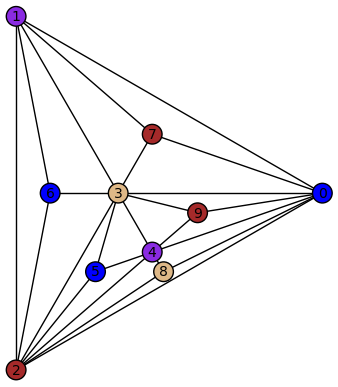

In [9]:
G = apollonian_network(10)
coloring = color_chordal_graph(G)
color_graph(G, coloring)

Apollonian network is a planar graph, therefore it should be colored with <= 4 colors

In [10]:
set(coloring.values())

{0, 1, 2, 3}

In [11]:
Verts = [11,2,12,44,12]

In [12]:
dict([(v, i) for (i, v) in enumerate(Verts)])

{11: 0, 2: 1, 12: 4, 44: 3}

In [17]:
RCG = random_chordal_graph(3)
is_chordal(RCG)
coloring = color_chordal_graph(RCG)

In [18]:
set(coloring.values())

{0, 1, 2, 3, 4, 5, 6, 7}

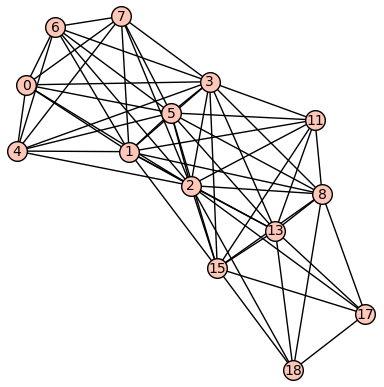

In [19]:
RCG.plot()

Compare with built-in algorithm. Can be very slow!

In [20]:
RCG.coloring()

[[0, 8], [1, 17], [2], [3, 18], [4, 11], [5], [6, 13], [7, 15]]

### Maximal cliques

In [21]:
verify_maximal_cliques(G, maximal_cliques_chordal(G))

True

In [22]:
maximal_cliques_chordal(G)

[{0, 3, 4, 9},
 {0, 2, 4, 8},
 {0, 1, 3, 7},
 {1, 2, 3, 6},
 {2, 3, 4, 5},
 {0, 2, 3, 4},
 {0, 1, 2, 3}]

In [23]:
verify_maximal_cliques(RCG, maximal_cliques_chordal(RCG))

True

In [24]:
maximal_cliques_chordal(RCG)

[{2, 8, 13, 15, 17, 18}, {1, 2, 3, 5, 8, 11, 13, 15}, {0, 1, 2, 3, 4, 5, 6, 7}]

In [25]:
G2 = graphs.RandomTree(10)
cliques2 = maximal_cliques_chordal(G2)
verify_maximal_cliques(G2, cliques2)

True

In [26]:
G3 = Graph('[~~~~~~DOiaOC`C`aG?a@COKP?wa@wa@{P?~CONw?K???o@?@_B?@_B_?o@w?K?^')
cliques3 = maximal_cliques_chordal(G3)
verify_maximal_cliques(G3, cliques3)

True